In [33]:
import sys
sys.path.append('../')

import numpy as np
import torch
import torch.nn as nn
# import torch.nn.functional as F

from dataset.omsignal_dataset import OMSignalDataset
from torchvision.transforms import Compose

# from dataset.preprocessor import Preprocessor
# from dataset.segmenter import PairedHeartBeatSegmenter,HeartBeatSegmenter
from dataset.to_float_tensor_transform import ToFloatTensorTransform
# from dataset.flip_transform import FlipTransform
# from dataset.shift_transform import ShiftTransform
# from dataset.gaussian_noise_transform import GaussianNoiseTransform
from dataset.encode_transform import Encode

from models.autoencoder import AutoEncoder_2l, AutoEncoder_3l, AutoEncoder_3l_v2

import matplotlib.pyplot as plt

# from models.multi_task_model import MultiTaskNet
# from models.multi_task_trainer import MultiTaskTrainer

# from utils.dataset_utils import generate_transformed_dataset
# from utils.ids_conversion import convert_back_ids,convert_ids

# from models.multi_task_predictions import multi_task_predict

# from utils.file_utils import read_data
# from scipy.stats import kendalltau, mode
# from sklearn.metrics import accuracy_score

import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D

In [34]:
from sklearn import decomposition
from sklearn import datasets

In [35]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
np.random.seed(5)

In [37]:
!ls /rap/jvb-000-aa/COURS2019/etudiants/submissions/b2pomt3/

AutoEncoder_2l_Adam_train4.tar
AutoEncoder_3l_Adam_train1.tar
AutoEncoder_3l_Adam_train4.tar
AutoEncoder_3l_Adam_train5.tar
AutoEncoder_3l_SGD_train2.tar
AutoEncoder_3l_v2_Adam_train1.tar
AutoEncoder_3l_v2_Adam_train3.tar
OMSignal_SegmentedData.dat
OMSignal_SegmentedData_Backup_2.dat
OMSignal_SegmentedData_rand.dat
OMSignal_SegmentedData_rand2.dat
OMSignal_SegmentedData_unlabeled_random.dat
OMSignal_SegmentedUnlabeledData.dat
OMSignal_Segmented_TrainLabeledData.dat
OMSignal_Segmented_TrainLabeledData_average.dat
OMSignal_Segmented_TrainLabeledData_encode.dat
OMSignal_Segmented_ValidationLabeledData.dat
OMSignal_Segmented_ValidationLabeledData_average.dat
OMSignal_Segmented_ValidationLabeledData_encode.dat
OMSignal_Single_TrainLabeledData.dat
OMSignal_Single_ValidationLabeledData.dat
SegmentedData
code
model


In [38]:
import matplotlib as mpl

def plot_pca(X, Y, n_components=2, name='PCA', fname=None):
    fig, plot = plt.subplots()
    fig.set_size_inches(8, 8)
    plt.prism()
    
    colorize = dict(c=Y, cmap=plt.cm.get_cmap('gist_ncar', 32))
    
    # Plot 2D graph if number of components chosen is 2
    if n_components == 2:
        plot.scatter(X[:, 0], X[:, 1], **colorize)
        plot.set_xticks(())
        plot.set_yticks(())

        count=0
        plt.tight_layout()
        plt.suptitle('{0} for User ID'.format(name))
        for label, x, y in zip(Y, X[:, 0], X[:, 1]):
            #Lets annotate every 1 out of 50 samples, otherwise graph will be cluttered with anotations
            if count % 75 == 0:
                plt.annotate(str(int(label)),xy=(x,y), color='black', weight='normal',size=10,bbox=dict(boxstyle="round4,pad=.5", fc="0.8"))
            count += 1
        if fname is not None:
            plt.savefig('{}{}.png'.format(SAVE_PATH, fname))
        plt.show()

    # Plot 3D graph if number of components chosen is 3
    if n_components == 3:
        
        ax = plt.axes(projection='3d')
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], **colorize)
        ax.view_init(azim=70, elev=50)
        if fname is not None:
            ax.figure.savefig('{}{}.png'.format(SAVE_PATH, fname))
        

In [39]:
SEG_LABELED = "/rap/jvb-000-aa/COURS2019/etudiants/submissions/b2pomt3/OMSignal_Segmented_TrainLabeledData.dat"
CHECKPOINT = "/rap/jvb-000-aa/COURS2019/etudiants/submissions/b2pomt3/AutoEncoder_3l_SGD_train2.tar"

SAVE_PATH = "./figures/"

In [40]:
labeled_dataset = OMSignalDataset(True, True, SEG_LABELED, None)
labeled_data = labeled_dataset.data
labeled_data.shape

(5007, 234)

In [41]:
X, y = labeled_data[:,:230], labeled_data[:,233:]
y = y.flatten()

print(X.shape)
print(y.shape)

(5007, 230)
(5007,)


In [80]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_2 = pca.transform(X)

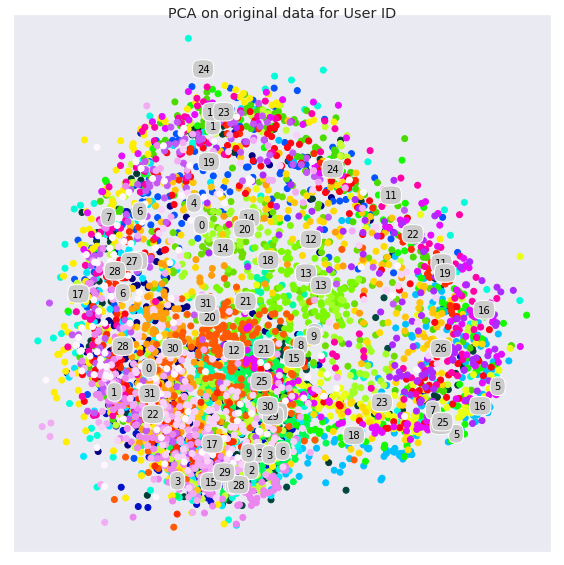

In [81]:
plot_pca(X_2, y, 2, 'PCA on original data', 'untransformed_pca_2')

In [82]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_3 = pca.transform(X)

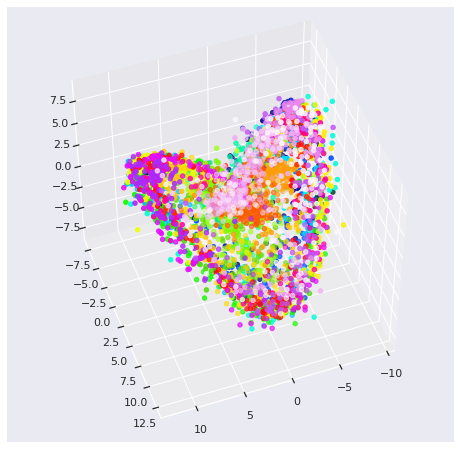

In [83]:
plot_pca(X_3, y, 3, 'PCA on original data', 'untransformed_pca_3')

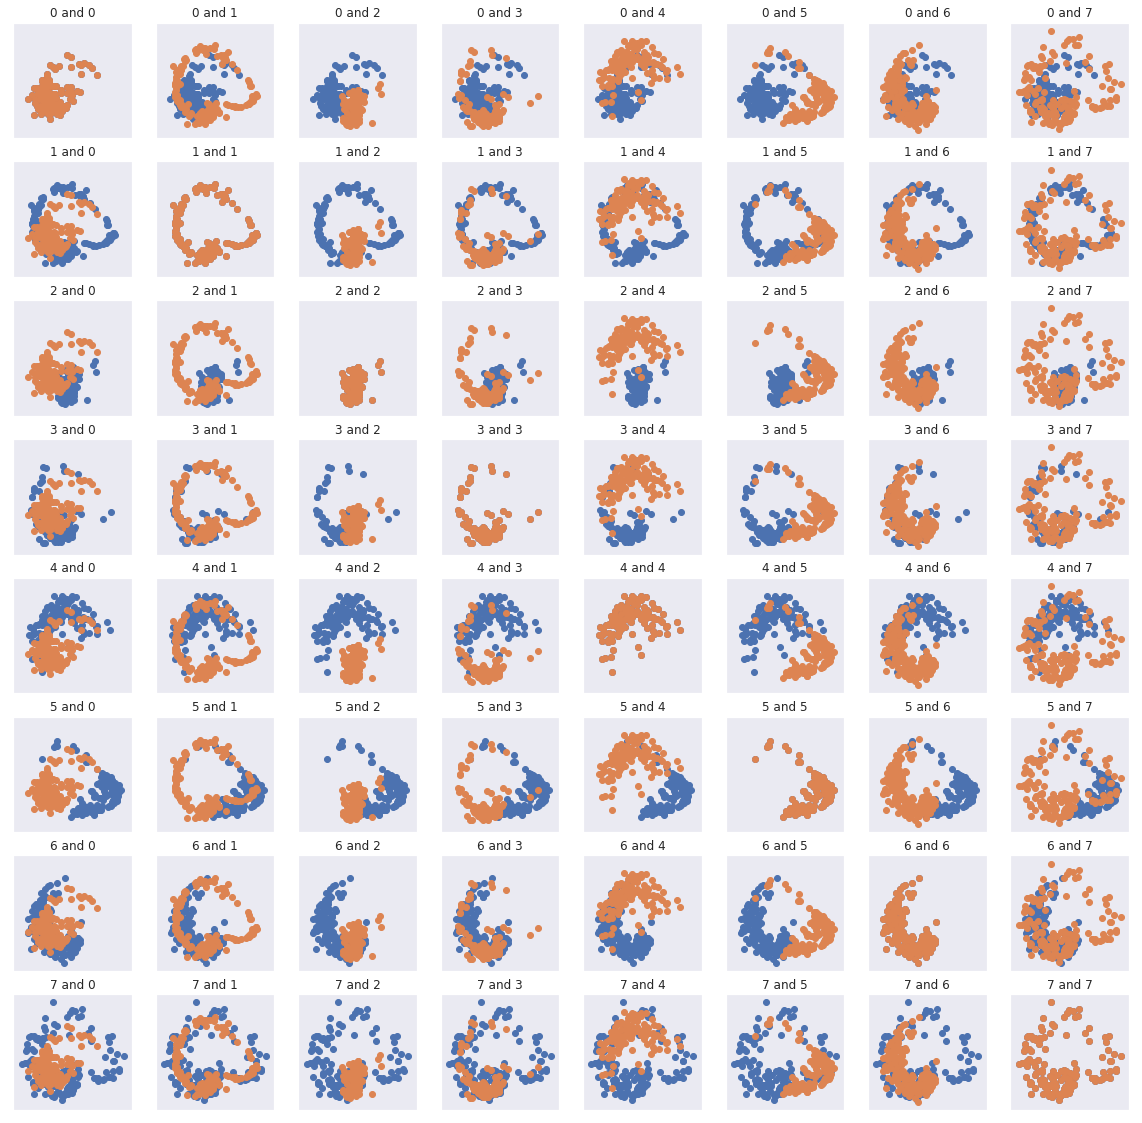

In [84]:
fig, axes = plt.subplots(nrows=8,ncols=8, sharex=True, sharey=True)
fig.set_size_inches(20, 20)
plt.prism()

for i in range(0,8):
    for j in range(0,8):

        xi = X_2[y == i]
        yi = y[y == i]
        xj = X_2[y == j]
        yj = y[y == j]
        axes[i,j].scatter(xi[:, 0], xi[:, 1])
        axes[i,j].scatter(xj[:, 0], xj[:, 1])
        axes[i,j].set_title('{0} and {1}'.format(i,j))
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())

plt.show()

## 2 Layer AutoEncoder

In [85]:
CHECKPOINT = "/rap/jvb-000-aa/COURS2019/etudiants/submissions/b2pomt3/AutoEncoder_2l_Adam_train4.tar"


In [45]:
!pwd

/home/user56/OMSignal_Block2/notebooks


In [52]:
encoder = AutoEncoder_2l(1, hidden_size=[32,64], kernel_size=[5,3,3,5], padding=[1,1,1,1], stride=[1,1,1,1])


encoder.load_state_dict(torch.load(
    CHECKPOINT, map_location=DEVICE)["model_state_dict"])
transform = Compose([ToFloatTensorTransform(), Encode(encoder)])
encoded_dataset = OMSignalDataset(True, True, SEG_LABELED, transform)

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1)
n = np.empty([0,916])
for idx, (inp, target) in enumerate(dataloader):
    inp = inp.squeeze(0).numpy()
    sample = np.concatenate([inp,target], axis=1)
    
    n = np.vstack([n, sample])

print(n.shape)


(5007, 916)


In [54]:
print(encoder)

AutoEncoder_2l(
  (encoder1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3648, out_features=1824, bias=True)
  (fc2): Linear(in_features=1824, out_features=912, bias=True)
  (fc3): Linear(in_features=912, out_features=1824, bias=True)
  (fc4): Linear(in_features=1824, out_features=3648, bias=True)
  (unpool1): MaxUnpool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (decoder1): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_s

In [55]:
X = n[:,:912]
y = n[:,915:]
print(X.shape)

(5007, 912)


In [56]:
y = y.flatten()

In [57]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_encoded_2 = pca.transform(X)

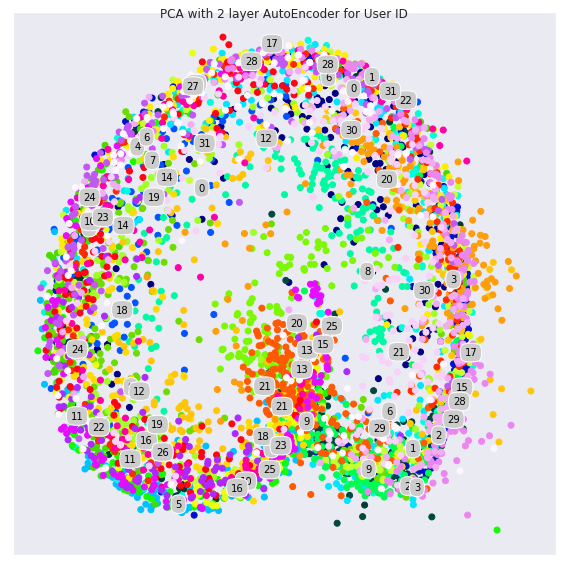

In [60]:
plot_pca(X_encoded_2, y, 2, 'PCA with 2 layer AutoEncoder', 'autoencoder_2l_pca_2')

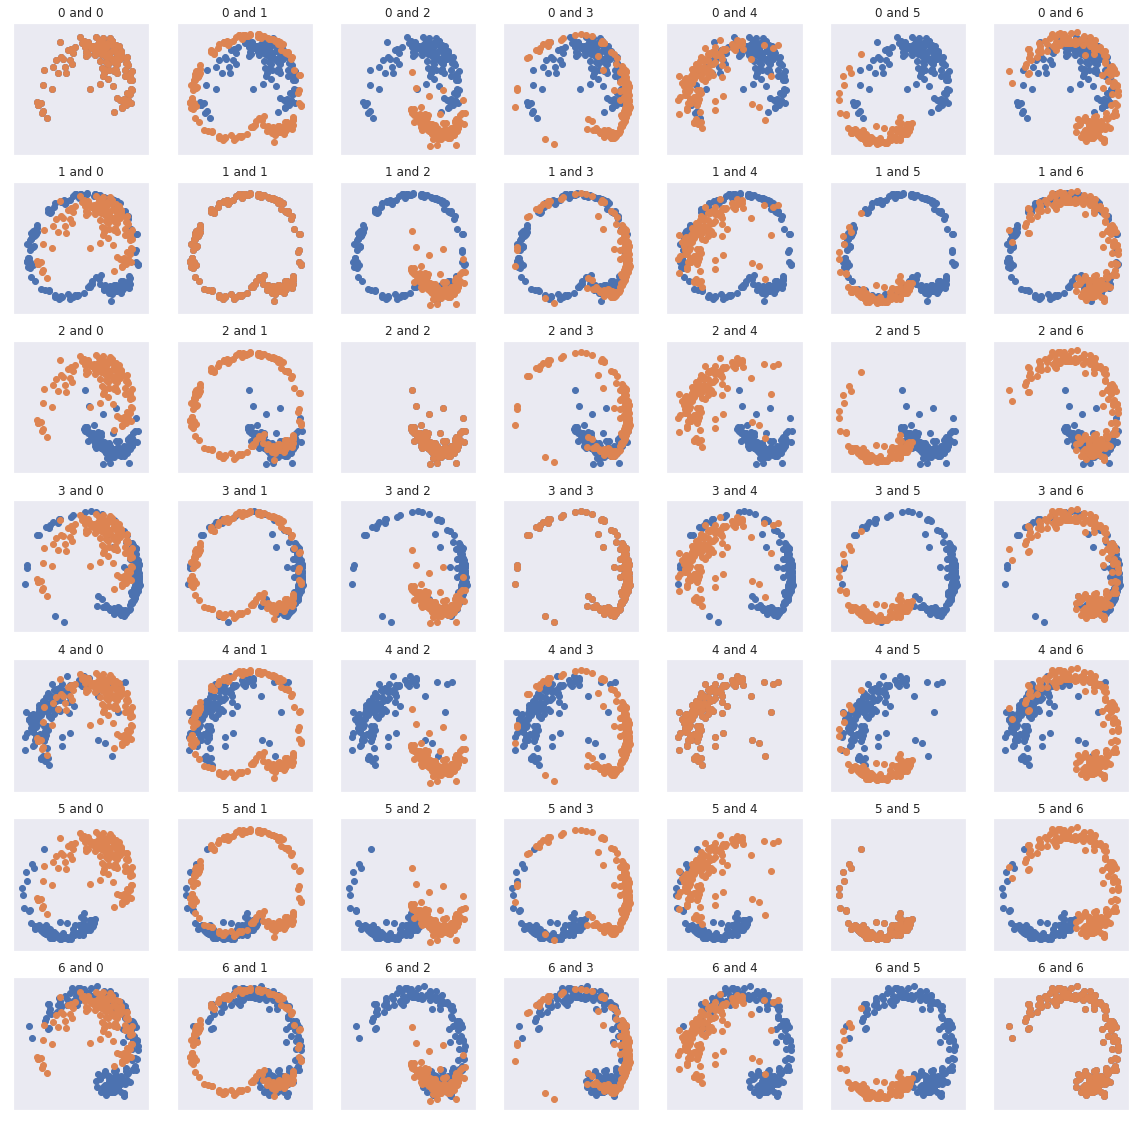

In [61]:
fig, axes = plt.subplots(nrows=7,ncols=7, sharex=True, sharey=True)
fig.set_size_inches(20, 20)
plt.prism()

for i in range(0,7):
    for j in range(0,7):

        xi = X_encoded_2[y == i]
        yi = y[y == i]
        xj = X_encoded_2[y == j]
        yj = y[y == j]
        axes[i,j].scatter(xi[:, 0], xi[:, 1])
        axes[i,j].scatter(xj[:, 0], xj[:, 1])
        axes[i,j].set_title('{0} and {1}'.format(i,j))
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
# plt.savefig('')
plt.show()

In [62]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_encoded_3 = pca.transform(X)


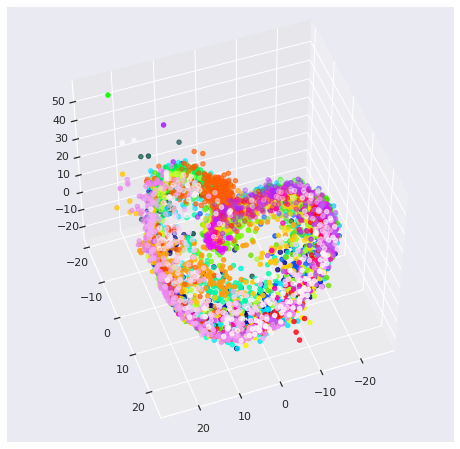

In [63]:
plot_pca(X_encoded_3, y, 3,'PCA with 2 layer AutoEncoder', 'autoencoder_2l_pca_3')

## 3 Layer AutoEncoder

In [10]:
CHECKPOINT = "/rap/jvb-000-aa/COURS2019/etudiants/submissions/b2pomt3/AutoEncoder_3l_Adam_train1.tar"

In [12]:
encoder = AutoEncoder_3l(1, hidden_size=[32,48,64], kernel_size=[5,4,3,3,5,5], padding=[1,1,1,1,1,1], stride=[1,1,1,1,1,1])

encoder.load_state_dict(torch.load(
    CHECKPOINT, map_location=DEVICE)["model_state_dict"])
transform = Compose([ToFloatTensorTransform(), Encode(encoder)])
encoded_dataset = OMSignalDataset(True, True, SEG_LABELED, transform)

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1)
n = np.empty([0,452])
for idx, (inp, target) in enumerate(dataloader):
    inp = inp.squeeze(0).numpy()
    sample = np.concatenate([inp,target], axis=1)
    n= np.vstack([n, sample])
print(n.shape)


(5007, 452)


In [13]:
print(encoder)

AutoEncoder_3l(
  (encoder1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv1d(32, 48, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv1d(48, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1792, out_features=896, bias=True)
  (fc2): Linear(in_features=896

In [14]:
X = n[:,:448]
y = n[:,451:]
y = y.flatten()

In [15]:
X.shape

(5007, 448)

In [16]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_encoded_2 = pca.transform(X)

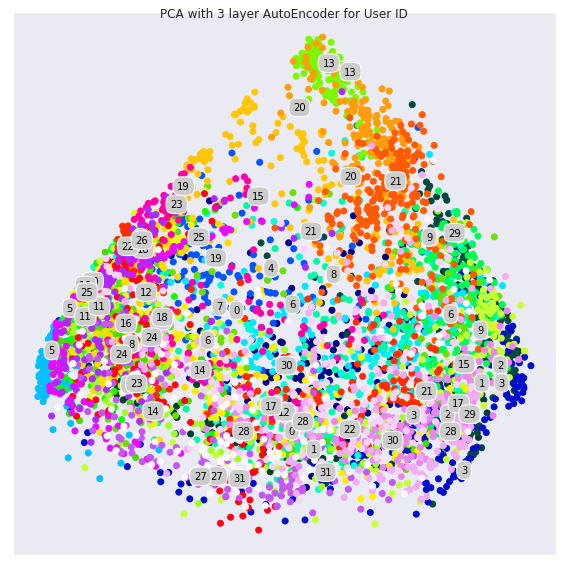

In [17]:
plot_pca(X_encoded_2, y, 2, 'PCA with 3 layer AutoEncoder', 'autoencoder_3l_pca_2')

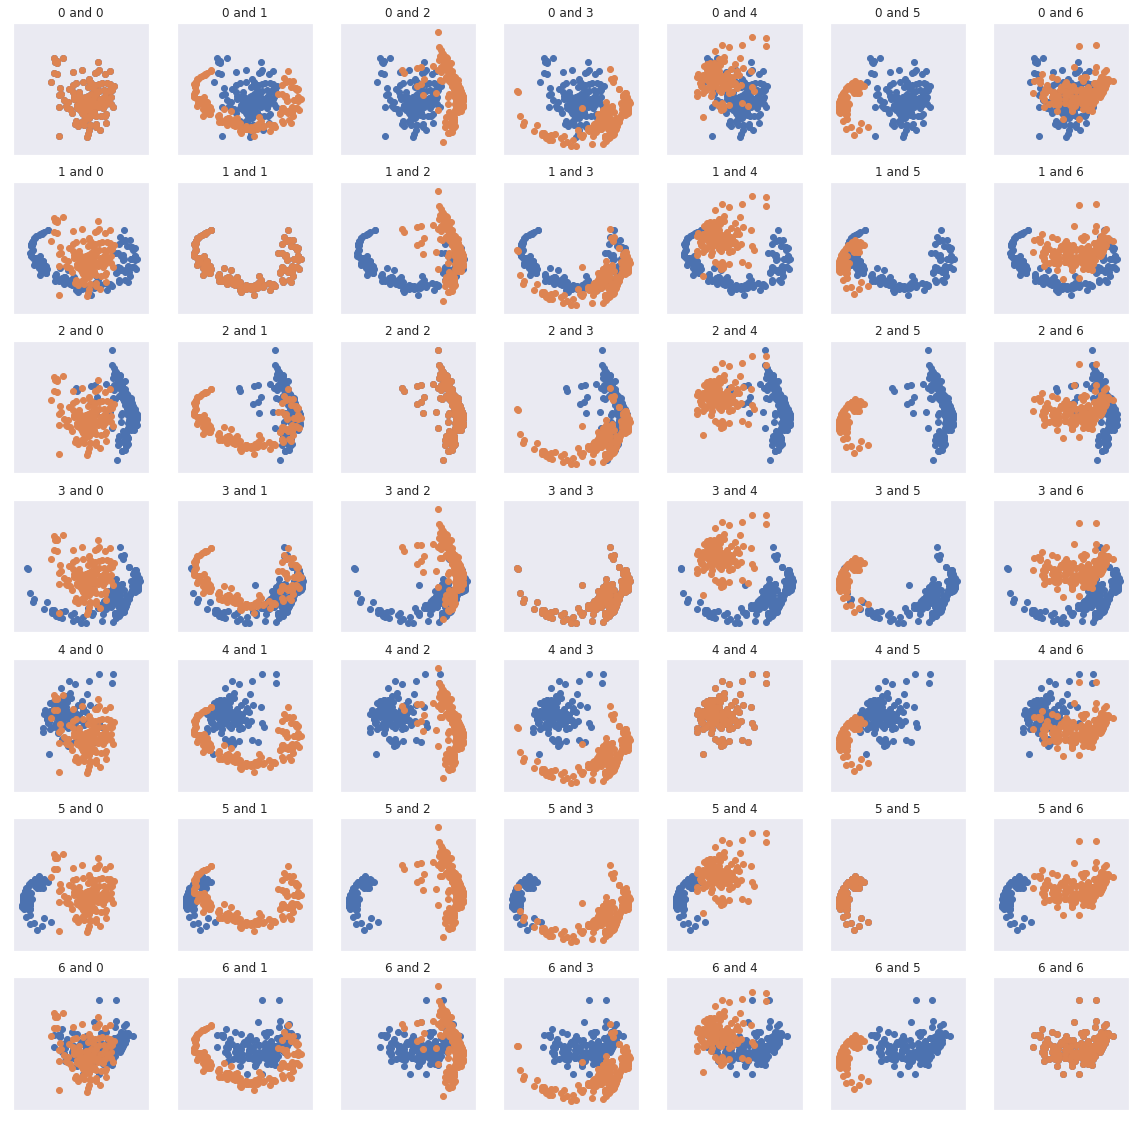

In [18]:
fig, axes = plt.subplots(nrows=7,ncols=7, sharex=True, sharey=True)
fig.set_size_inches(20, 20)
plt.prism()

for i in range(0,7):
    for j in range(0,7):

        xi = X_encoded_2[y == i]
        yi = y[y == i]
        xj = X_encoded_2[y == j]
        yj = y[y == j]
        axes[i,j].scatter(xi[:, 0], xi[:, 1])
        axes[i,j].scatter(xj[:, 0], xj[:, 1])
        axes[i,j].set_title('{0} and {1}'.format(i,j))
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
# plt.savefig('')
plt.show()

In [19]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_encoded_3 = pca.transform(X)

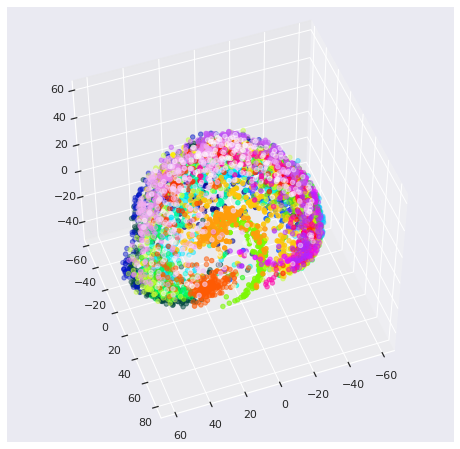

In [20]:
plot_pca(X_encoded_3, y, 3, 'PCA with 3 layer AutoEncoder', 'autoencoder_3l_pca_3')

## 3 layer Autoencoder with Adam and smaller hidden_dimension

In [42]:
CHECKPOINT = "/rap/jvb-000-aa/COURS2019/etudiants/submissions/b2pomt3/AutoEncoder_3l_Adam_train5.tar"

In [43]:
encoder = AutoEncoder_3l(1, hidden_size=[8,16,32], kernel_size=[5,4,3,3,5,5], padding=[1,1,1,1,1,1], stride=[1,1,1,1,1,1])

encoder.load_state_dict(torch.load(
    CHECKPOINT, map_location=DEVICE)["best_model"])
transform = Compose([ToFloatTensorTransform(), Encode(encoder)])
encoded_dataset = OMSignalDataset(True, True, SEG_LABELED, transform)

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1)
n = np.empty([0,228])
for idx, (inp, target) in enumerate(dataloader):
    inp = inp.squeeze(0).numpy()
    sample = np.concatenate([inp,target], axis=1)
    n= np.vstack([n, sample])

print(n.shape)
    


(5007, 228)


In [44]:
print(encoder)

AutoEncoder_3l(
  (encoder1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=896, out_features=448, bias=True)
  (fc2): Linear(in_features=448, ou

In [45]:
X = n[:,:224]
y = n[:,227:]
y = y.flatten()

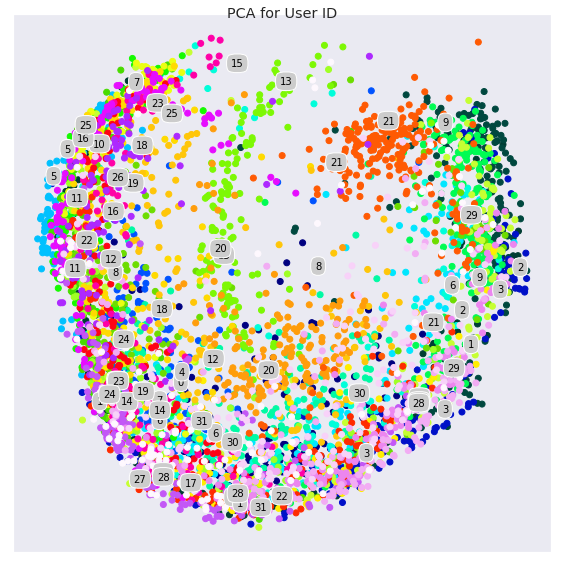

In [46]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_encoded_2 = pca.transform(X)
plot_pca(X_encoded_2, y, 2)

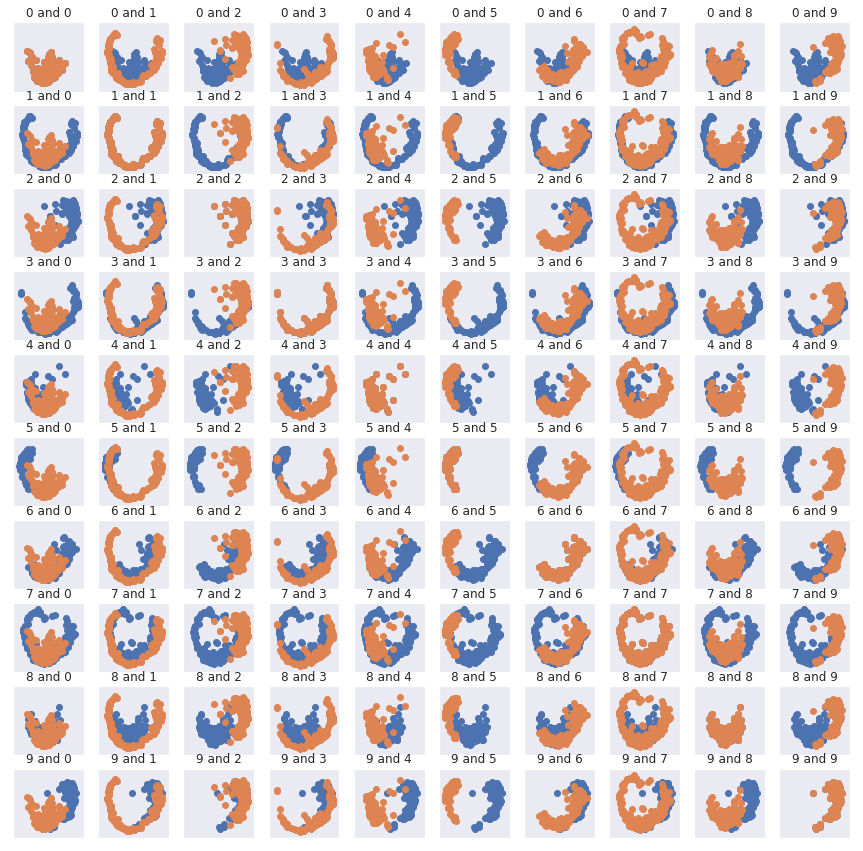

In [47]:
fig, axes = plt.subplots(nrows=10,ncols=10, sharex=True, sharey=True)
fig.set_size_inches(15, 15)
plt.prism()

for i in range(0,10):
    for j in range(0,10):

        xi = X_encoded_2[y == i]
        yi = y[y == i]
        xj = X_encoded_2[y == j]
        yj = y[y == j]
        axes[i,j].scatter(xi[:, 0], xi[:, 1])
        axes[i,j].scatter(xj[:, 0], xj[:, 1])
        axes[i,j].set_title('{0} and {1}'.format(i,j))
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
# plt.savefig('')
plt.show()

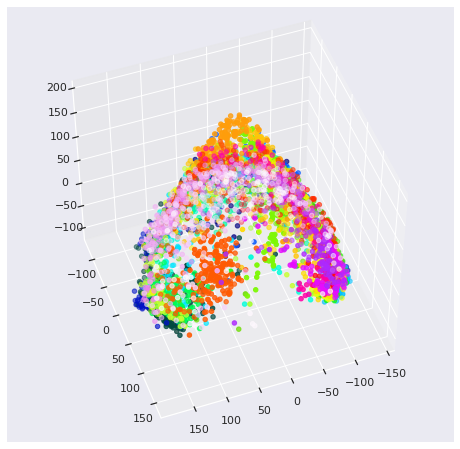

In [48]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_encoded_3 = pca.transform(X)
plot_pca(X_encoded_3, y, 3)

## Autocoder 3l second architecture

In [49]:
CHECKPOINT = "/rap/jvb-000-aa/COURS2019/etudiants/submissions/b2pomt3/AutoEncoder_3l_v2_Adam_train1.tar"

In [50]:
encoder = AutoEncoder_3l_v2(1, hidden_size=[16,32,64], kernel_size=[13,9,5,5,10,13], padding=[6,4,2,2,4,6], stride=[1,1,1,1,1,1])

encoder.load_state_dict(torch.load(
    CHECKPOINT, map_location=DEVICE)["best_model"])
transform = Compose([ToFloatTensorTransform(), Encode(encoder)])
encoded_dataset = OMSignalDataset(True, True, SEG_LABELED, transform)

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1)
n = np.empty([0,916])
for idx, (inp, target) in enumerate(dataloader):
    inp = inp.squeeze(0).numpy()
    sample = np.concatenate([inp,target], axis=1)
    n= np.vstack([n, sample])

print(n.shape)
    


(5007, 916)


In [51]:
print(encoder)

AutoEncoder_3l_v2(
  (encoder1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(13,), stride=(1,), padding=(6,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (fc1): Linear(in_features=3648, out_features=1824, bias=True)
  (fc2): Linear(in_features=1824, out_features=912, bias=True)
  (fc3): Linear(in_features=912, out_features=182

In [52]:
X = n[:,:912]
y = n[:,915:]
y = y.flatten()

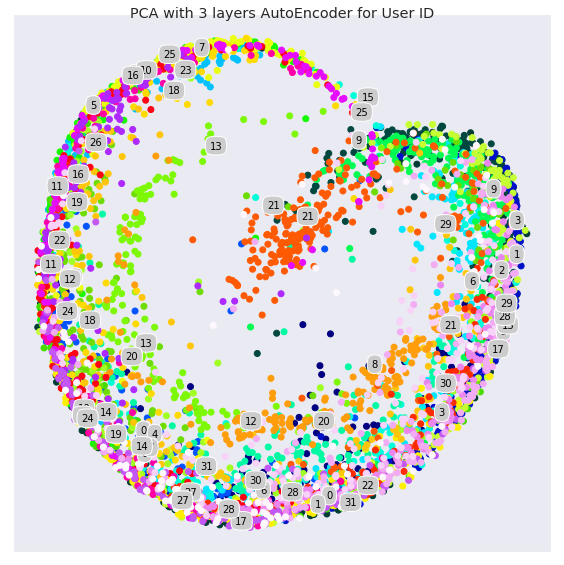

In [53]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_encoded_2 = pca.transform(X)
plot_pca(X_encoded_2, y, 2, 'PCA with 3 layers AutoEncoder', 'autoencoder_3l_v2_pca_2')

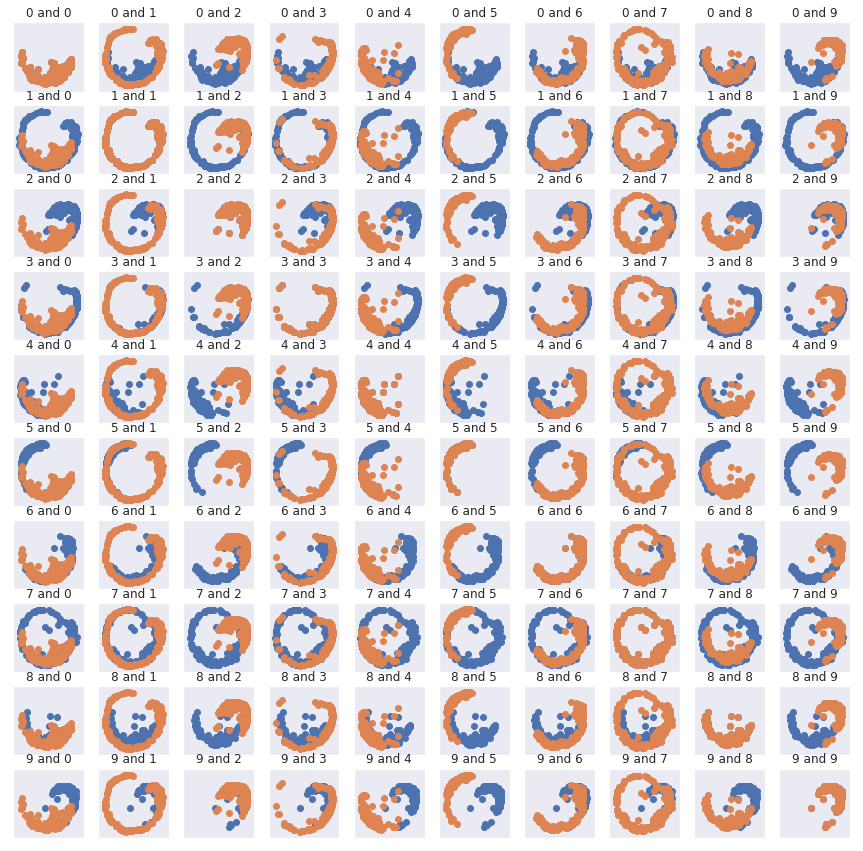

In [54]:
fig, axes = plt.subplots(nrows=10,ncols=10, sharex=True, sharey=True)
fig.set_size_inches(15, 15)
plt.prism()

for i in range(0,10):
    for j in range(0,10):

        xi = X_encoded_2[y == i]
        yi = y[y == i]
        xj = X_encoded_2[y == j]
        yj = y[y == j]
        axes[i,j].scatter(xi[:, 0], xi[:, 1])
        axes[i,j].scatter(xj[:, 0], xj[:, 1])
        axes[i,j].set_title('{0} and {1}'.format(i,j))
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
# plt.savefig('')
plt.show()

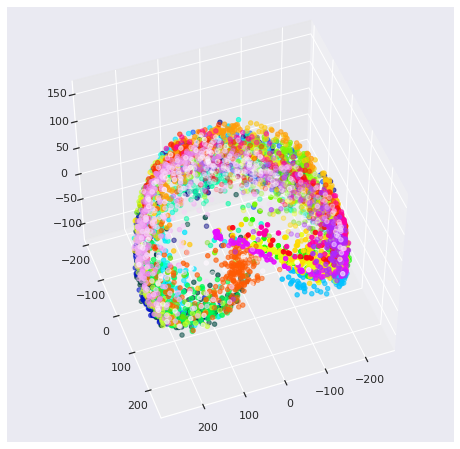

In [55]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_encoded_3 = pca.transform(X)
plot_pca(X_encoded_3, y, 3, 'PCA with 3 layers AutoEncoder', 'autoencoder_3l_v2_pca_3')

In [57]:
Xi = np.any(N_)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()